# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.07699999827891588


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Implementation details

`experiences = random.choices(self.memory, k=self.batch_size)` - randomness with replacement is a key for success of DDPG implementation.



####  Importing libraries

In [1]:
import datetime
import time
import random
import copy
from collections import namedtuple, deque
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Starting environment

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


####  Setting parameters

`BUFFER_SIZE = int(5e5)` - a buffer should be big to accumulate maximum experience for training.

`BATCH_SIZE = 256` - big batch size mean more generic update during training by taking it in multiple of 8 .

`GAMMA = 0.99` - discount factor I have kept it big as Miguel Morales said keep your gamma factor big.

`TAU = 1e-3` , `LR_ACTOR = 1e-3` &amp; `LR_CRITIC = 1e-3` I kept all this quite generic and widely used parameters.

In [3]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = "cpu"

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

####  Creating `class Actor` that will act on behalf of the agent

In [5]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

#### Creating `class Critic` which "criticize" our `class Actor`.

In [6]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### Creating `class Agent` that will represent our agent

In [7]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, epsilon=1.0, epsilon_decay=1e-6):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
#         self.cache = ReplayBuffer(action_size, int(6e4), BATCH_SIZE, random_seed)
        
        
        for target_param, param in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target_param.data.copy_(param.data)

    
    def step(self, state, action, reward, next_state, done, epoch):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
#         self.memory.add(state, action, reward, next_state, done)
#         for states, actions, rewards, next_states, dones in zip(state, action, reward, next_state, done):
#           self.memory.add(states, actions, rewards, next_states, dones)
        self.memory.add(state, action, reward, next_state, done)

#             self.cache.add(states, actions, rewards, next_states, dones)
            

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and epoch % 20 == 0:
            for num in range(18):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
#             for num in range(3):
#                 experiences = self.cache.sample()
#                 self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        self.epsilon -= self.epsilon_decay
        self.noise.reset()


    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

#### Noise

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.05):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state

#### Replay buffer

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""   
        for num in range(20):
            e = self.experience(state[num], action[num], reward[num], next_state[num], done[num])
            self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.choices(self.memory, k=self.batch_size)        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

####  Instanstiating `class Agent`

In [10]:
agent = Agent(state_size=33, action_size=4, random_seed=2)

#### Training our model

In [11]:
def ddpg(n_episodes=1000):
    print('Start time: ',datetime.datetime.now())
    all_agents = np.array([]).reshape(0,20)
    start_time = time.time()
    print('\rEP, Min, Max, Average, AV100, Time')
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(20)                          # initialize the score (for each agent)
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in range(100000000):
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished            
            agent.step(states, actions, rewards, next_states, dones,t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)           
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        all_agents = np.concatenate((all_agents, scores.reshape(1,20)), axis=0)
        mean_100 = np.mean(all_agents[-101:-1], axis=0)      
        print('{}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'\
              .format(str(i_episode).zfill(3), np.min(scores), np.max(scores), np.mean(scores), float(np.mean(mean_100)), 
                      time.time() - timestep), end="\n")                                   
        if  np.all(mean_100 > 30.0):            
            end_time = time.time()
            print('\nSolved in {:d} episodes!\tAvg Score: {:.2f}, time: {}'.format(i_episode, float(np.mean(mean_100)), 
                                                                                   end_time-start_time))
            for num, scr in enumerate(mean_100):
                print('Agent {} average: {:.2f} '.format(num+1, scr))        
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('End time: ',datetime.datetime.now())    
            return all_agents         


####  Training started

In [12]:
scores = ddpg()

Start time:  2019-08-12 21:10:10.629150
EP, Min, Max, Average, AV100, Time


C:\Users\andreiliphd\Anaconda3\envs\drlnd\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\andreiliphd\Anaconda3\envs\drlnd\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\andreiliphd\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater


001, 0.00, 1.69, 0.47, nan, 12.37
002, 0.00, 0.21, 0.06, 0.47, 12.07
003, 0.00, 1.16, 0.17, 0.26, 12.21
004, 0.00, 0.65, 0.10, 0.23, 12.31
005, 0.00, 1.96, 0.28, 0.20, 12.38
006, 0.00, 0.90, 0.27, 0.22, 13.00
007, 0.00, 0.90, 0.38, 0.22, 13.01
008, 0.43, 2.27, 1.20, 0.25, 13.18
009, 0.72, 2.30, 1.24, 0.37, 13.35
010, 0.60, 2.59, 1.49, 0.46, 13.46
011, 0.61, 2.57, 1.42, 0.57, 13.47
012, 0.45, 4.85, 1.54, 0.64, 13.87
013, 0.00, 2.52, 1.28, 0.72, 14.03
014, 0.00, 3.81, 1.62, 0.76, 14.26
015, 0.16, 3.45, 1.69, 0.82, 14.52
016, 0.66, 4.14, 2.00, 0.88, 15.21
017, 0.47, 3.93, 2.18, 0.95, 15.48
018, 0.54, 3.93, 1.79, 1.02, 15.56
019, 1.11, 3.71, 2.51, 1.07, 15.83
020, 1.21, 4.15, 2.29, 1.14, 16.04
021, 0.95, 5.42, 3.38, 1.20, 16.13
022, 1.49, 4.41, 2.90, 1.30, 16.40
023, 0.81, 4.72, 2.73, 1.38, 16.37
024, 0.53, 6.13, 3.31, 1.43, 16.72
025, 0.35, 4.87, 2.52, 1.51, 17.22
026, 0.64, 6.78, 2.74, 1.55, 17.32
027, 1.14, 5.31, 3.21, 1.60, 17.36
028, 1.50, 7.55, 3.99, 1.66, 17.28
029, 0.65, 6.42, 3.20

In [13]:
env.close()

#### Visualizing rewards across 20 workers

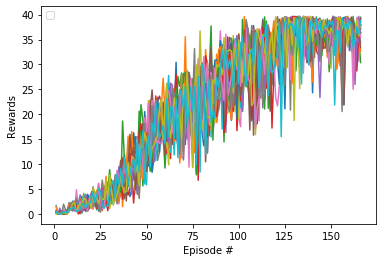

In [29]:
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Rewards')
plt.xlabel('Episode #')

### Future Improvements

1. Neural networks can be tuned for a better performance by trial and error and much experimentation with hyperparameter tuning 

2. Add prioritized experience replay, rather than selecting experience tuples randomly which can improve learning by increasing the probability that rare and important experience vectors are sampled.

3. We can tryto experiment with different algorithms like  Trust Region Policy Optimization (TRPO), [Proximal Policy Optimization (PPO)](Proximal Policy Optimization Algorithms), or Distributed Distributional Deterministic Policy Gradients (D4PG).